Load HyperParameters

In [1]:
from neat_src import loadHyp, updateHyp
from domain import load_task
from neat_src import DataGatherer, Neat 
from domain.config import games
from domain.task_gym import GymTask

game = games["slimevolley"]
task = GymTask(game)

hyp_default = 'p/default_neat.json'
hyp_adjust = "p/volley.json"
fileName = "volley"

hyp = loadHyp(pFileName=hyp_default, load_task=load_task)
updateHyp(hyp,load_task,hyp_adjust)

# neat = Neat(hyp)

	*** Running with hyperparameters:  p/volley.json 	***


#### Convert Policy model to Ind in Neat 

In [2]:
import json
import numpy as np
import gym, os
import slimevolleygym
import slimevolleygym.mlp as mlp
from slimevolleygym.mlp import games as games
from slimevolleygym.mlp import Model
from slimevolleygym import multiagent_rollout as rollout


# Settings
random_seed = 612
population_size = 128
total_tournaments = 500000
save_freq = 1000


# Log results
logdir = "ga_rotation_je"
if not os.path.exists(logdir):
  os.makedirs(logdir)

def mutate(param, param_count):
  return param + np.random.normal(size=param_count) * 0.1

curr_policy = Model(games['slimevolleylite'])
prev_policy = Model(games['slimevolleylite'])

/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_11623/869475039.py:26: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  curr_policy = Model(games['slimevolleylite'])
/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_11623/869475039.py:27: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  prev_policy = Model(games['slimevolleylite'])


Initialize Indiv object & Visualize it

# of Connections in ANN:  91


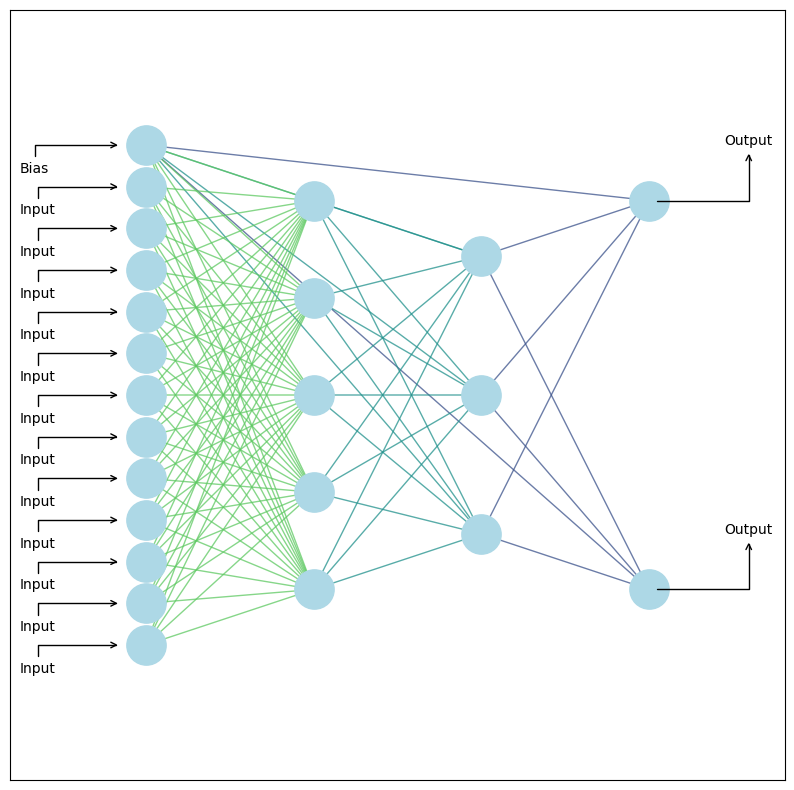

In [4]:
# Slime Environment Specific model -> Ind convertion function 
from neat_src import Ind, initIndiv
from vis.viewInd import viewInd 

temp_shapes = [(12, 5), (5, 3), (3, 2)] # debug getlayer functional variable 

indiv = Ind.from_shapes(temp_shapes)
indiv.express()

# visualize individual network 
fig, ax = viewInd(indiv, "slimevolley") # this is in-correct, edge is not correctly assigned ...

In [5]:
# Policy model <--> Indiv object 
